In [1]:
from PIL import Image
from torchvision import transforms
import torch
from src.utils import plot_tensors

/home/tom/anaconda3/envs/deep_learn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.AugLayer import *
from src.FreeAugment import *
from src.dAugmentations.dRotation import *
from src.dAugmentations.dBrightness import *
from src.dAugmentations.dColor import *
from src.dAugmentations.dIdentity import *
from src.dAugmentations.dShearX import *
from src.dAugmentations.dShearY import *
from src.dAugmentations.dTranslateX import *
from src.dAugmentations.dTranslateY import *
from src.dAugmentations.dContrast import *
from src.dAugmentations.dInvert import *
from src.dAugmentations.dEqualize import *
from src.dAugmentations.dSolarize import *
from src.dAugmentations.dPosterize import *
from src.dAugmentations.dSharpness import *
from src.dAugmentations.dCutout import *
from src.dAugmentations.dAutoContrast import *

In [3]:
CUTOUT = 60
low_init = .125
high_init = .875
image_size = (1600, 1000)

In [4]:
import os
import yaml
import wandb

with open('src/configs/FreeAugmentConf.yaml', 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)
wandb_run = wandb.init(config=config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [5]:
image_path = 'data/images/cool_dog1.jpg'

In [6]:
rank = 0
device = torch.device(f'cuda:{rank}' if torch.cuda.is_available() else 'cpu')

DAugmentation.set_skip_prob(wandb.config['aug_skips']['prob']['init'])
DAugmentation.image_size = image_size

stoch_batch_mag = wandb.config["stoch_batch_mag"]

k_d_augmentations = [
    [
        DShearX(low_m=low_init, high_m=high_init, device=device, stoch_batch_mag=stoch_batch_mag),
        DShearY(low_m=low_init, high_m=high_init, device=device, stoch_batch_mag=stoch_batch_mag),
        DTranslateX(low_m=low_init, high_m=high_init, device=device, stoch_batch_mag=stoch_batch_mag),
        DTranslateY(low_m=low_init, high_m=high_init, device=device, stoch_batch_mag=stoch_batch_mag),
        DRotation(low_m=low_init, high_m=high_init, device=device, stoch_batch_mag=stoch_batch_mag),
        DInvert(device=device),
        DEqualize(device=device),
        DSolarize(low_m=low_init, high_m=high_init, device=device, stoch_batch_mag=stoch_batch_mag),
        DPosterize(low_m=low_init, high_m=high_init, device=device, stoch_batch_mag=stoch_batch_mag),
        DContrast(low_m=low_init, high_m=high_init, device=device, stoch_batch_mag=stoch_batch_mag),
        DColor(low_m=low_init, high_m=high_init, device=device, stoch_batch_mag=stoch_batch_mag),
        DBrightness(low_m=low_init, high_m=high_init, device=device, stoch_batch_mag=stoch_batch_mag),
        DSharpness(low_m=low_init, high_m=high_init, device=device, stoch_batch_mag=stoch_batch_mag),
        DAutoContrast(device=device),
    ]
    for _ in range(wandb.config["k"])
]

aa_module = FreeAugment(k_d_augmentations, device).to(device)

In [7]:
# Load the image using PIL
image = Image.open(image_path).convert("RGB")

In [8]:
# Resizing and conversion to tensor (without normalization)
transform = transforms.Compose([
    transforms.Resize(image_size),  # resize to image_size pixels
    transforms.ToTensor(),          # convert to tensor (automatically scales pixel values to [0, 1])
])

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # optional normalization for models

In [9]:
image_tensor = transform(image).unsqueeze(0).to(device)
image_tensor.shape

torch.Size([1, 3, 1600, 1000])

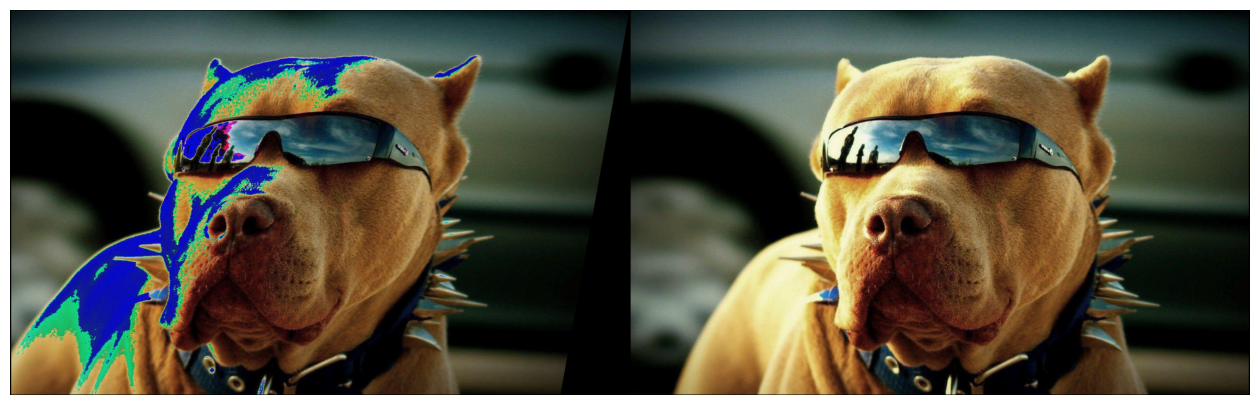

In [10]:
augmented_image = aa_module(image_tensor)
plot_tensors([augmented_image, image_tensor], figsize=(16,5))

In [11]:
dummy_loss = augmented_image.sum()
dummy_loss.backward()

In [12]:
aa_module.betas.grad

tensor([ 85289.7109,   1907.2961, -26710.0566, -60486.9258], device='cuda:0')